# Dependencies

In [3]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from modules.DynamicsProfiles import *

%matplotlib inline

# Step 1: Data Processing
### Cross Validated
- https://stats.stackexchange.com/questions/109644/how-to-normalize-time-series
- https://stats.stackexchange.com/questions/84321/why-and-when-do-we-normalize-time-series-data
- https://stats.stackexchange.com/questions/90777/normalize-row-or-column-while-each-row-is-an-observation
- https://stats.stackexchange.com/questions/41704/how-and-why-do-normalization-and-feature-scaling-work
- https://stackoverflow.com/questions/43467597/should-i-normalize-my-features-before-throwing-them-into-rnn

### Paper
- http://www.cs.ucr.edu/~eamonn/SIGKDD_trillion.pdf

### ML Mastery
- https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
- https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/

### CS231n
- http://cs231n.github.io/neural-networks-2/

In [4]:
def get_data():
    data = {}
    with h5py.File("data/model_db_100.h5", "r") as infile:
        label_names = infile.attrs["label_names"]
        for model_name, model_members in infile.items():
            data[model_name] = [np.array(model_data) for model_data in model_members.values()]
        
    return data, label_names

In [5]:
data, label_names = get_data()

In [9]:
classes = data.keys()
num_classes = len(classes)
labels = np.identity(num_classes)
label_names = []
X_data = []
y_data = []
ONE_HOT = True

for i, (model_name, model_data) in enumerate(data.items()):
    label_names.append(model_name)
    intensities = []
    for intensity in model_data:
        X_data.append(intensity)
        if ONE_HOT:
            y_data.append(labels[i])
        else:
            y_data.append(np.argmax(labels[i]))
        
X_data = np.array(X_data)
y_data = np.array(y_data)

### Scale Data

In [53]:
X_data_scaled = preprocessing.scale(X_data, axis=1)

### Check data

In [ ]:
random_i = np.random.randint(X_data_scaled.shape[0])
plt.plot(X_data[random_i])
plt.title(label_names[np.argmax(y_data[random_i])])
plt.show()

### Train, Validation, Test splits

In [ ]:
X_data_expanded = np.expand_dims(X_data_scaled, axis=2)

X_train, X_test, y_train, y_test = train_test_split(X_data_expanded, y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

data = {
    "training" : {"X" : X_train, "y" : y_train},
    "validation" : {"X" : X_valid, "y" : y_valid},
    "test" : {"X" : X_test, "y" : y_test}
}

# TensorFlow - Class Implementation

## Dependencies

In [1]:
import tensorflow as tf
import tensorflow.contrib.rnn as rnn

# AutoEncoder
### Example
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py

In [2]:
def autoencode_data(X_data):
    seq_length = X_data.shape[1]
    n_hidden_1 = 90
    n_hidden_2 = 75
    n_hidden_3 = 90
    n_output = seq_length
    
    # Input / Outputs
    X = tf.placeholder(tf.float32, [None, seq_length])
    network = X
    
    # Encoder
    W1 = tf.Variable(tf.random_normal([seq_length, n_hidden_1]))
    b1 = tf.Variable(tf.random_normal([n_hidden_1]))
    
    network = tf.nn.tanh(tf.matmul(network, W1) + b1)
    
    W2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
    b2 = tf.Variable(tf.random_normal([n_hidden_2]))
    
    network = tf.matmul(network, W2) + b2
    encoded_layer = network
    
    # Decoder
    W3 = tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3]))
    b3 = tf.Variable(tf.random_normal([n_hidden_3]))
    
    network = tf.nn.tanh(tf.matmul(network, W3) + b3)
    
    W4 = tf.Variable(tf.random_normal([n_hidden_3, n_output]))
    b4 = tf.Variable(tf.random_normal([n_output]))
    
    network = tf.matmul(network, W4) + b4
    
    # Eval
    y_pred = network
    y_true = X
    
    # Loss
    loss = tf.reduce_mean(tf.square(y_pred - y_true))
    
    # Optimizers
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)
    
    # Init Variables
    init = tf.global_variables_initializer()
    
    n_epochs = 50000
    patience_threshold = 100
    
    with tf.Session() as sess:
        init.run()
        loss_history = []
        for epoch_i in range(n_epochs):
        
            _, loss_val = sess.run([train_op, loss], feed_dict={X: X_data})
            loss_history.append(loss_val)
            
            if epoch_i > 2 and loss_history[-2] - loss_history[-1] < 0.00001:
                patience_counter +=1 
            else:
                patience_counter = 0
                
            # Display logs per step
            sys.stdout.write('\rStep: {:5d}/{:5d} -- Minibatch Loss: {:0.3f} -- Patience Counter: {:4d}/{:4d}\t'.format(epoch_i, n_epochs, loss_val, patience_counter, patience_threshold))
            
            if patience_counter > patience_threshold:
                print("\nStopping Early!")
                break
            
        X_test_pred = y_pred.eval(feed_dict={X: X_data})
        encoded_data = encoded_layer.eval(feed_dict={X: X_data})
    return X_test_pred, encoded_data

In [183]:
predicted, encoded = autoencode_data(X_data)

Step: 49999/50000 -- Minibatch Loss: 3.930 -- Patience Counter:    0/ 100			

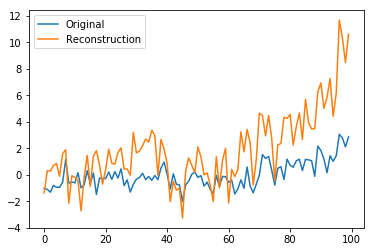

In [184]:
index = 100
plt.plot(X_data_scaled[index], label="Original")
plt.plot(predicted[index], label="Reconstruction")
plt.legend()

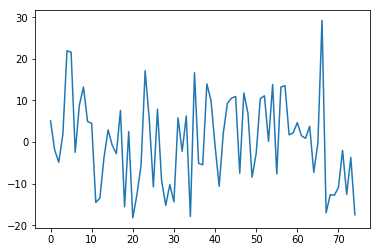

In [185]:
plt.plot(encoded[index])

# VAE
### Source
- https://github.com/hwalsuklee/tensorflow-mnist-VAE/blob/master/vae.py

In [152]:
# Gaussian MLP as encoder
def gaussian_MLP_encoder(x, n_hidden, n_output, keep_prob):
    with tf.variable_scope("gaussian_MLP_encoder"):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(x, w0) + b0
        h0 = tf.nn.elu(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.tanh(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer
        # borrowed from https: // github.com / altosaar / vae / blob / master / vae.py
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output * 2], initializer=w_init)
        bo = tf.get_variable('bo', [n_output * 2], initializer=b_init)
        gaussian_params = tf.matmul(h1, wo) + bo

        # The mean parameter is unconstrained
        mean = gaussian_params[:, :n_output]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, n_output:])

    return mean, stddev

In [153]:
# Bernoulli MLP as decoder
def bernoulli_MLP_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("bernoulli_MLP_decoder", reuse=reuse):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(z, w0) + b0
        h0 = tf.nn.tanh(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.elu(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer-mean
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output], initializer=w_init)
        bo = tf.get_variable('bo', [n_output], initializer=b_init)
        y = tf.sigmoid(tf.matmul(h1, wo) + bo)

    return y

In [149]:
# Gateway
def autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob):

    # encoding
    mu, sigma = gaussian_MLP_encoder(x_hat, n_hidden, dim_z, keep_prob)

    # sampling by re-parameterization technique
    z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

    # decoding
    y = bernoulli_MLP_decoder(z, n_hidden, dim_img, keep_prob)
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

    # loss
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO

    return y, z, loss, -marginal_likelihood, KL_divergence

In [150]:
def decoder(z, dim_img, n_hidden):

    y = bernoulli_MLP_decoder(z, n_hidden, dim_img, 1.0, reuse=True)

    return y

In [180]:
def VAE(X_data, dim_z=20, n_hidden=500):
    seq_length = X_data.shape[1]
    
    tf.reset_default_graph()
    
    # input placeholders
    # In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
    x_hat = tf.placeholder(tf.float32, shape=[None, seq_length], name='input_img')
    x = tf.placeholder(tf.float32, shape=[None, seq_length], name='target_img')

    # dropout
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    # input for PMLR
    z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

    # network architecture
    y, z, loss, neg_marginal_likelihood, KL_divergence = autoencoder(x_hat, x, seq_length, dim_z, n_hidden, keep_prob)

    # optimization
    train_op = tf.train.AdamOptimizer().minimize(loss)
    
    # Init Variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        init.run()
        for epoch_i in range(n_epochs):
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                    (train_op, loss, neg_marginal_likelihood, KL_divergence),
                     feed_dict={x_hat: X_data, x: X_data, keep_prob : 0.9})
          
            # Display logs per step;
            sys.stdout.write("\r epoch: {} -- L_tot: {:3.2f} -- L_likelihood: {:3.2f} -- L_divergence: {:3.2f}".format(epoch_i, tot_loss, loss_likelihood, loss_divergence))
           

In [181]:
VAE(X_data)

 epoch: 499 -- L_tot: nan -- L_likelihood: nan -- L_divergence: nan	30	 122.58	

## RNN Class

- See this for LSTM implementation and other goodies

https://stackoverflow.com/questions/40318812/tensorflow-rnn-weight-matrices-initialization

In [ ]:
class RNN(object):
    def __init__(self, architecture, n_epochs=10, batch_size=256, seed=42):
        self._architecture = architecture
        self._n_epochs = n_epochs
        self._batch_size = batch_size
        
        self._seed = seed
        
        date = str(datetime.now())
        str_arch = "_".join(map(lambda y: str(y), self._architecture["layer_architecture"]))
        self._save_name = "RNN_arch_{}__time_{}".format(str_arch, date)
        
        self._build_network()
        self._sess = tf.Session()
        
        # Save Metrics
        self.metrics = {
            "epochs" : [],
            "training" : [],
            "validation" : [],
            "loss" : [],
            "test" : None
        }
    
    def _build_network(self):
        n_hidden = self._architecture["layer_architecture"]
        n_layers = len(n_hidden)
        n_inputs = self._architecture["n_inputs"]
        n_classes = self._architecture["n_classes"]
        seq_length = self._architecture["seq_length"]
        eta = self._architecture["eta"]
        self._cell_type = self._architecture["cell_type"]
        
        # BUILD
        # ***************************************************************
        print("Building Model...")
        # Seed 
        tf.set_random_seed(self._seed)

        # Reset default graph
        tf.reset_default_graph()

        # Inputs / Outputs
        # ------------------------------------------------------------
        X = tf.placeholder(tf.float32, [None, seq_length, n_inputs])
        y = tf.placeholder(tf.float32, [None, n_classes])
        # ------------------------------------------------------------

        # RNN Cells
        # ---------------------------------------------------------------------------------
        if self._cell_type is "LSTM":
            cells = [rnn.BasicLSTMCell(n_hidden[layer_i]) for layer_i in range(n_layers)]
        elif self._cell_type is "GRU":
            cells = [rnn.GRUCell(n_hidden[layer_i]) for layer_i in range(n_layers)]
        else:
            cells = [rnn.BasicRNNCell(n_hidden[layer_i]) for layer_i in range(n_layers)]
            
        multi_lstm_cells = rnn.MultiRNNCell(cells, state_is_tuple=True)
        outputs, states = tf.nn.dynamic_rnn(multi_lstm_cells, X, dtype=tf.float32)
        # ---------------------------------------------------------------------------------

        # Fully Connected Layer
        # --------------------------------
        if self._cell_type is "LSTM":
            final_state = states[-1][-1]
        else:
            final_state = states[-1]
            
        input_shape = final_state.get_shape().as_list()[-1]
        with tf.variable_scope("fc_layer"):
            W = tf.get_variable("W_fc", [input_shape, num_classes], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=1.0 / np.sqrt(input_shape)))
            b = tf.get_variable("b_fc", [num_classes], initializer=tf.constant_initializer(0.0))

        logits = tf.matmul(final_state, W) + b
        # --------------------------------

        # Xentropy and loss
        # --------------------------------
        xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        # --------------------------------

        # Optimizer
        # --------------------------------
        optimizer = tf.train.AdamOptimizer(learning_rate=eta)
        train_op = optimizer.minimize(loss)
        # --------------------------------

        # Evaluation
        # --------------------------------
        prediction = tf.argmax(tf.nn.softmax(logits), 1)
        y_actual = tf.argmax(y, 1)

        correct_predictions = tf.equal(prediction, y_actual)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        # --------------------------------

        # SAVER
        saver = tf.train.Saver()
        # ***************************************************************

        # Global Variables Initializer
        init = tf.global_variables_initializer()
        
        self._model = {
            "X" : X,
            "y" : y,
            "seq_length" : seq_length,
            "loss" : loss,
            "train_op" : train_op,
            "accuracy" : accuracy,
            "init" : init,
            "saver" : saver
        }
    
    def train(self, data):
        
        # Parse Data
        X_train = data["training"]["X"]
        y_train = data["training"]["y"]
        X_valid = data["validation"]["X"]
        y_valid = data["validation"]["y"]
        X_test = data["test"]["X"]
        y_test = data["test"]["y"]
        
        
        # Parse out train, valid, test data
        n_batches = X_train.shape[0] // self._batch_size
        
        # TRAIN
        # ***************************************************************
        print("Training...")

        self._sess.run(self._model["init"])
        batch_ave = 0
        
        try:
            for epoch_i in range(self._n_epochs):
                epoch_loss = 0
                train_acc = 0
                batch_deltas = []
                print("\nEpoch {}/{}\n".format(epoch_i+1, self._n_epochs))
                X_shuff, y_shuff = shuffle(X_train, y_train)
                for batch_i in range(n_batches):
                    batch_t0 = time.time()
                    
                    X_batch = X_shuff[batch_i*self._batch_size:batch_i*self._batch_size+self._batch_size]
                    y_batch = y_shuff[batch_i*self._batch_size:batch_i*self._batch_size+self._batch_size]

                    ops = [self._model["train_op"], self._model["loss"], self._model["accuracy"]]
                    train_dict = {
                        self._model["X"] : X_batch,
                        self._model["y"] : y_batch
                    }

                    _, batch_loss, batch_train_acc = self._sess.run(ops, feed_dict=train_dict)

                    epoch_loss += batch_loss / n_batches
                    train_acc += batch_train_acc / n_batches

                    # Progress bar
                    # ------------------------------------------------
                    batch_tf = time.time()
                    batch_delta = batch_tf - batch_t0
                    batch_deltas.append(batch_delta)
                    batch_ave = np.mean(batch_deltas)
                    eta = batch_ave * (n_batches - batch_i+1)
                    eta_min = int(eta // 60)
                    eta_sec = int(eta % 60)

                    bar_length = 20
                    progress = int((batch_i+1) / float(n_batches) * bar_length)
                    percent_complete = (batch_i+1) / float(n_batches) * 100

                    sys.stdout.write("\r{}/{} [{:21s}] {:5.2f}% - ETA {:2d}m {:2d}s - Loss: {:0.3f}".format(batch_i+1, n_batches, "="*progress+">"+"-"*(bar_length-progress), percent_complete, eta_min, eta_sec, epoch_loss))
                    # ------------------------------------------------

                # Validation
                # ------------------------------------------------
                valid_dict = {
                    self._model["X"] : X_valid,
                    self._model["y"] : y_valid
                }

                valid_acc = self._sess.run(self._model["accuracy"], feed_dict=valid_dict)
                # ------------------------------------------------

                # Save metrics
                # ------------------------------------------------
                self.metrics["epochs"].append(epoch_i)
                self.metrics["loss"].append(epoch_loss)
                self.metrics["training"].append(train_acc)
                self.metrics["validation"].append(valid_acc)
                # ------------------------------------------------

                # Print
                print("\nLoss: {:0.3f} -- Train Acc: {:0.3f} -- Valid Acc: {:0.3f}\n".format(epoch_loss, train_acc, valid_acc))

            # Test
            # ------------------------------------------------
            test_dict = {
                self._model["X"] : X_test,
                self._model["y"] : y_test
            }
            test_acc = self._sess.run(self._model["accuracy"], feed_dict=test_dict)
            # ------------------------------------------------

            # Save metrics
            self.metrics["test"] = test_acc

            # Print
            print("\nTest accuracy: {:0.3f}".format(test_acc))

            # SAVE
            self._model["saver"].save(self._sess, "models/{}.ckpt".format(self._save_name))
            # ***************************************************************
        
        except KeyboardInterrupt:
            # SAVE
            self._model["saver"].save(self._sess, "models/RNN_custom.ckpt")

        

### Run Model

In [ ]:
def run(arch, n_epochs):
    rnn_arch = {
        "layer_architecture" : arch,
        "n_classes" : num_classes,
        "seq_length" : X_data.shape[1],
        "n_inputs" : 1,
        "eta" : 0.01,
        "cell_type" : "GRU"
    }

    rnn_params = {
        "architecture" : rnn_arch,
        "n_epochs" : n_epochs,
        "batch_size" : 1024
    }
    rnn_clf = RNN(**rnn_params)
    
    rnn_clf.train(data)
    
    return rnn_clf

### Train Model

In [ ]:
archs = [[32, 16, 8], [32, 32, 16], [64, 32, 16], [128, 64, 32], [128, 64, 32, 16]]
n_epochs = [25, 25, 25, 35, 50]
clfs = [run(arch, n_epoch) for arch, n_epoch in zip(archs, n_epochs)]

### Plotting

In [ ]:
fig, axes = plt.subplots(len(clfs), 1, figsize=(20,15))

for i, rnn_clf in enumerate(clfs):
    arch = archs[i]
    epochs = rnn_clf.metrics["epochs"]
    loss = rnn_clf.metrics["loss"]
    training = rnn_clf.metrics["training"]
    validation = rnn_clf.metrics["validation"]
    test_score = rnn_clf.metrics["test"]
    maximum = float(np.max(loss))
    minimum = float(np.min(loss))
    loss_normed = [(x - minimum) / maximum for x in loss]

    axes[i].plot(epochs, training, "r", label="Training")
    axes[i].plot(epochs, validation, "b--", label="Validation")
    axes[i].plot(epochs, loss_normed, "orange", label="Loss")
    axes[i].set_title("Arch: {} -- Cell: {} \n Test: {:0.2f}".format(arch, "GRU", test_score))
    axes[i].set_ylim([0, 1.0])
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Accuracy")
    axes[i].legend()
    
fig.subplots_adjust(hspace=.75)
plt.savefig("results.png")
plt.show()

# TF Implementation - Function Version

In [ ]:
def RNN_fxn(n_epochs=10, batch_size=256, seed=42):
    
    # PARAMS
    num_batches = X_train.shape[0] // batch_size
    
    seq_length = X_train.shape[1]
    num_hidden = [128, 128]
    num_layers = len(num_hidden)
    num_inputs = 1
    
    
    # Save Metrics
    metrics = {
        "epochs" : [],
        "training" : [],
        "validation" : [],
        "loss" : [],
        "test" : None
    }
    
    # BUILD
    # ***************************************************************
    print("Building Model...")
    # Seed 
    tf.set_random_seed(seed)
    
    # Reset default graph
    tf.reset_default_graph()

    # Inputs / Outputs
    # --------------------
    X = tf.placeholder(tf.float32, [None, seq_length, num_inputs])
    y = tf.placeholder(tf.float32, [None, num_classes])
    # --------------------
    
    # RNN Cells
    # --------------------
    cells = [rnn.BasicLSTMCell(num_hidden[layer_i]) for layer_i in range(num_layers)]
    multi_lstm_cells = rnn.MultiRNNCell(cells, state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(multi_lstm_cells, X, dtype=tf.float32)
    # --------------------
    
    # Fully Connected Layer
    # --------------------------------
    final_state = states[-1][-1]
    input_shape = final_state.get_shape().as_list()[-1]
    with tf.variable_scope("fc_layer"):
        W = tf.get_variable("W_fc", [input_shape, num_classes], tf.float32, tf.random_normal_initializer(stddev=1.0 / np.sqrt(input_shape)))
        b = tf.get_variable("b_fc", [num_classes], initializer=tf.constant_initializer(0.0))
    
    logits = tf.matmul(final_state, W) + b
    # --------------------------------
    
    # Xentropy and loss
    # --------------------------------
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    # --------------------------------
    
    # Optimizer
    # --------------------------------
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)
    # --------------------------------
    
    # Evaluation
    # --------------------------------
    prediction = tf.argmax(tf.nn.softmax(logits), 1)
    y_actual = tf.argmax(y, 1)
    
    correct_predictions = tf.equal(prediction, y_actual)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    # --------------------------------
    
    # Global Variables Initializer
    init = tf.global_variables_initializer()
    
    # SAVER
    saver = tf.train.Saver()
    # ***************************************************************
    
    
    # TRAIN
    # ***************************************************************
    print("Training...")
    
    with tf.Session() as sess:
        init.run()
        for epoch_i in range(n_epochs):
            epoch_loss = 0
            train_acc = 0
            X_shuff, y_shuff = shuffle(X_train, y_train)
            for batch_i in range(num_batches):
                X_batch = X_shuff[batch_i*batch_size:batch_i*batch_size+batch_size]
                y_batch = y_shuff[batch_i*batch_size:batch_i*batch_size+batch_size]

                ops = [train_op, loss, accuracy]
                train_dict = {
                    X : X_batch,
                    y : y_batch
                }
                
                _, batch_loss, batch_train_acc = sess.run(ops, feed_dict=train_dict)
                
                epoch_loss += batch_loss / num_batches
                train_acc += batch_train_acc / num_batches
                
                # Progress bar
                # ------------------------------------------------
                bar_length = 30
                progress = int((batch_i+1) / float(num_batches) * bar_length)
                percent_complete = (batch_i+1) / float(num_batches) * 100
                sys.stdout.write("\rBatch {}/{} -- Loss: {:0.3f} -- Progress: [{:31s}] {:5.2f}% ".format(batch_i, num_batches, epoch_loss, "="*progress+">"+"-"*(bar_length-progress), percent_complete))
                # ------------------------------------------------
            
            # Validation
            # ------------------------------------------------
            valid_dict = {
                X : X_valid,
                y : y_valid
            }
            
            valid_acc = accuracy.eval(feed_dict=valid_dict)
            # ------------------------------------------------
            
            # Save metrics
            # ------------------------------------------------
            metrics["epochs"].append(epoch_i)
            metrics["loss"].append(epoch_loss)
            metrics["training"].append(train_acc)
            metrics["validation"].append(valid_acc)
            # ------------------------------------------------

            # Print
            print("\nEpoch {}/{} -- Loss: {:0.3f} -- Train Acc: {:0.3f} -- Valid Acc: {:0.3f}\n".format(epoch_i+1, self._n_epochs, epoch_loss, train_acc, valid_acc))
                
        # Test
        # ------------------------------------------------
        test_dict = {
            X : X_test,
            y : y_test
        }
        test_acc = accuracy.eval(feed_dict=test_dict)
        # ------------------------------------------------
        
        # Save metrics
        metrics["test"] = test_acc
        
        # Print
        print("\nTest accuracy: {:0.3f}".format(test_acc))
        
        # SAVE
        saver.save(sess, "models/RNN_custom.ckpt")
    # ***************************************************************
    
    return metrics

In [ ]:
metrics = RNN_fxn(n_epochs=5)

# Keras Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Params
look_back = 1
seq_length = X_train.shape[1]
n_epochs = 10

# Build Model
# ========================================================================
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(seq_length, look_back)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# ========================================================================

# Train
model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, verbose=1)

# Scores
train_score = model.evaluate(X_train, y_train, verbose=1)
test_score = model.evaluate(X_test, y_test, verbose=1)
print("Train Score: {:0.2f} -- Test Score: {:0.2f}".format(train_score[1], test_score[1]))